In [1]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_selection.relevance import calculate_relevance_table

In [4]:
path = 'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\'
fd001_train_path = os.path.join(path, 'train_FD001.txt')
columns = [
    'unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3',
] + [f'sensor_{i}' for i in range(1, 22)]  # 26 columns in total

# Read the data with the appropriate column names
fd001_train_data = pd.read_csv(fd001_train_path, delim_whitespace=True, header=None, names=columns)

# Display the first few rows of the dataset
fd001_train_data.head()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
# Compute Remaining Useful Life (RUL) for each engine in the training data
fd001_train_data['max_cycle'] = fd001_train_data.groupby('unit_number')['time_in_cycles'].transform('max')

def piecewise_linear_rul(row, start=125):
    if row['time_in_cycles'] <= start:
        # Before the degradation starts, RUL decreases linearly with a gentle slope
        return row['max_cycle'] - row['time_in_cycles']
    else:
        # After the degradation start, continue to degrade naturally
        return max(0, row['max_cycle'] - row['time_in_cycles'])

# Apply the piecewise linear RUL calculation to the dataset
fd001_train_data['piecewise_rul'] = fd001_train_data.apply(piecewise_linear_rul, axis=1)

In [6]:
window_size = 40  

rolled_df = roll_time_series(
    fd001_train_data,
    column_id='unit_number',
    column_sort='time_in_cycles',
    max_timeshift=window_size - 1,  
    min_timeshift=0,
    rolling_direction=1  
)

rolled_df.head()

Rolling: 100%|██████████| 52/52 [00:08<00:00,  5.87it/s]


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,piecewise_rul,id
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191.0,"(1, 1)"
100,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191.0,"(1, 2)"
101,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190.0,"(1, 2)"
300,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191.0,"(1, 3)"
301,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190.0,"(1, 3)"


In [18]:
selected_columns = ['unit_number', 'time_in_cycles', 'id', 'sensor_2', 'sensor_3', 'sensor_4', 
                    'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 
                    'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 
                    'sensor_17', 'sensor_20', 'sensor_21']
rolled_df

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,piecewise_rul,id
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191.0,"(1, 1)"
100,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191.0,"(1, 2)"
101,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190.0,"(1, 2)"
300,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191.0,"(1, 3)"
301,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190.0,"(1, 3)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685635,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8.4956,0.03,397,2388,100.0,38.49,22.9735,200,4.0,"(100, 200)"
685636,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8.5139,0.03,395,2388,100.0,38.30,23.1594,200,3.0,"(100, 200)"
685637,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8.5646,0.03,398,2388,100.0,38.44,22.9333,200,2.0,"(100, 200)"
685638,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8.5389,0.03,395,2388,100.0,38.29,23.0640,200,1.0,"(100, 200)"


In [20]:
long_rolled_df = rolled_df.melt(
    id_vars=['id', 'time_in_cycles', 'unit_number'], 
    value_vars=['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 
                'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 
                'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21'], 
    var_name='feature', 
    value_name='value'
)

In [22]:
rolled_features = extract_features(
    long_rolled_df,
    column_id='id',  
    column_sort='time_in_cycles',  
    column_kind='feature',  
    column_value='value',  
    n_jobs=4
)


rolled_features.head()

Feature Extraction: 100%|██████████| 20/20 [28:42<00:00, 86.14s/it]  


sensor_11__variance_larger_than_standard_deviation  \
1 1                                                0.0    
  2                                                0.0    
  3                                                0.0    
  4                                                0.0    
  5                                                0.0    

     sensor_11__has_duplicate_max  sensor_11__has_duplicate_min  \
1 1                           0.0                           0.0   
  2                           0.0                           0.0   
  3                           0.0                           0.0   
  4                           0.0                           0.0   
  5                           0.0                           0.0   

     sensor_11__has_duplicate  sensor_11__sum_values  sensor_11__abs_energy  \
1 1                       0.0                  47.47              2253.4009   
  2                       0.0                  94.96              4508.7010   
  3                       0.0                 142.23              6743.1539   
  4                       0.0                 189.36              8964.3908   
  5                       0.0                 236.64             11199.7892   

     sensor_11__mean_abs_change  sensor_11__mean_change  \
1 1                         NaN                     NaN   
  2                    0.020000                0.020000   
  3                    0.120000               -0.100000   
  4                    0.126667               -0.113333   
  5                    0.132500               -0.047500   

     sensor_11__mean_second_derivative_central  sensor_11__median  ...  \
1 1                                        NaN              47.47  ...   
  2                                        NaN              47.48  ...   
  3                                  -0.120000              47.47  ...   
  4                                  -0.040000              47.37  ...   
  5                                   0.021667              47.28  ...   

     sensor_9__fourier_entropy__bins_5  sensor_9__fourier_entropy__bins_10  \
1 1                                NaN                                 NaN   
  2                          -0.000000                           -0.000000   
  3                           0.693147                            0.693147   
  4                           1.098612                            1.098612   
  5                           0.636514                            1.098612   

     sensor_9__fourier_entropy__bins_100  \
1 1                                  NaN   
  2                            -0.000000   
  3                             0.693147   
  4                             1.098612   
  5                             1.098612   

     sensor_9__permutation_entropy__dimension_3__tau_1  \
1 1                                                NaN   
  2                                                NaN   
  3                                          -0.000000   
  4                                           0.693147   
  5                                           0.636514   

     sensor_9__permutation_entropy__dimension_4__tau_1  \
1 1                                                NaN   
  2                                                NaN   
  3                                                NaN   
  4                                          -0.000000   
  5                                           0.693147   

     sensor_9__permutation_entropy__dimension_5__tau_1  \
1 1                                                NaN   
  2                                                NaN   
  3                                                NaN   
  4                                                NaN   
  5                                               -0.0   

     sensor_9__permutation_entropy__dimension_6__tau_1  \
1 1                                                NaN   
  2                                                NaN   
  3              

In [24]:
impute(rolled_features)

y = rolled_df.groupby('id')['piecewise_rul'].last()

relevance_table = calculate_relevance_table(rolled_features, y, fdr_level=0.05)

# Display the relevance table with p-values
relevance_table[['feature', 'p_value', 'relevant']]

c:\Users\owner\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['sensor_11__fft_coefficient__attr_"real"__coeff_21'
 'sensor_11__fft_coefficient__attr_"real"__coeff_22'
 'sensor_11__fft_coefficient__attr_"real"__coeff_23' ...
 'sensor_9__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'sensor_9__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'sensor_9__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,feature,p_value,relevant
feature,,,
sensor_11__sum_values,sensor_11__sum_values,0.0,True
"sensor_4__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","sensor_4__change_quantiles__f_agg_""var""__isabs...",0.0,True
"sensor_4__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","sensor_4__change_quantiles__f_agg_""mean""__isab...",0.0,True
"sensor_4__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","sensor_4__change_quantiles__f_agg_""var""__isabs...",0.0,True
"sensor_4__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","sensor_4__change_quantiles__f_agg_""var""__isabs...",0.0,True
...,...,...,...
sensor_9__ratio_beyond_r_sigma__r_7,sensor_9__ratio_beyond_r_sigma__r_7,NaN,False
sensor_9__ratio_beyond_r_sigma__r_10,sensor_9__ratio_beyond_r_sigma__r_10,NaN,False
sensor_9__count_above__t_0,sensor_9__count_above__t_0,NaN,False


In [43]:
top_20_features_by_pvalue = relevance_table.sort_values('p_value').head(20)

# Extract the feature names
top_20_feature_names = top_20_features_by_pvalue['feature']

# Filter the extracted features to keep only the top 20 based on p-value
top_20_extracted_features = rolled_features[top_20_feature_names]
top_20_extracted_features.head()

sensor_11__sum_values  \
1 1                  47.47   
  2                  94.96   
  3                 142.23   
  4                 189.36   
  5                 236.64   

     sensor_12__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"  \
1 1                                           521.6569                           
  2                                           521.6569                           
  3                                           521.6569                           
  4                                           521.6569                           
  5                                           521.6569                           

     sensor_8__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"  \
1 1                                              0.006                     
  2                                              0.006                     
  3                                              0.006                     
  4                                              0.006                     
  5                                              0.006                     

     sensor_12__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"  \
1 1                                          -4.768817                    
  2                                          -4.768817                    
  3                                          -4.768817                    
  4                                          -0.894756                    
  5                                          -2.319098                    

     sensor_12__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"  \
1 1                                           0.000062                  
  2                                           0.000062                  
  3                                           0.000062                  
  4                                           0.789694                  
  5                                           0.165882                  

     sensor_8__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"  \
1 1                                              0.005                     
  2                                              0.005                     
  3                                              0.005                     
  4                                              0.005                     
  5                                              0.005                     

     sensor_8__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"  \
1 1                                           0.002429                     
  2                                           0.002429                     
  3                                           0.002429                     
  4                                           0.002429                     
  5                                           0.002429                     

     sensor_8__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"  \
1 1                                           0.002857                    
  2                                           0.002857                    
  3                                           0.002857                    
  4                                           0.002857                    
  5                                           0.002857                    

     sensor_8__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"  \
1 1                                             0.0025                    
  2                                             0.0025                    
  3                                             0.0025                    
  4                                             0.0025                    
  5                                             0.0025                    

     sensor_8__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"  \
1 1                                          2388.0763                          
  2   

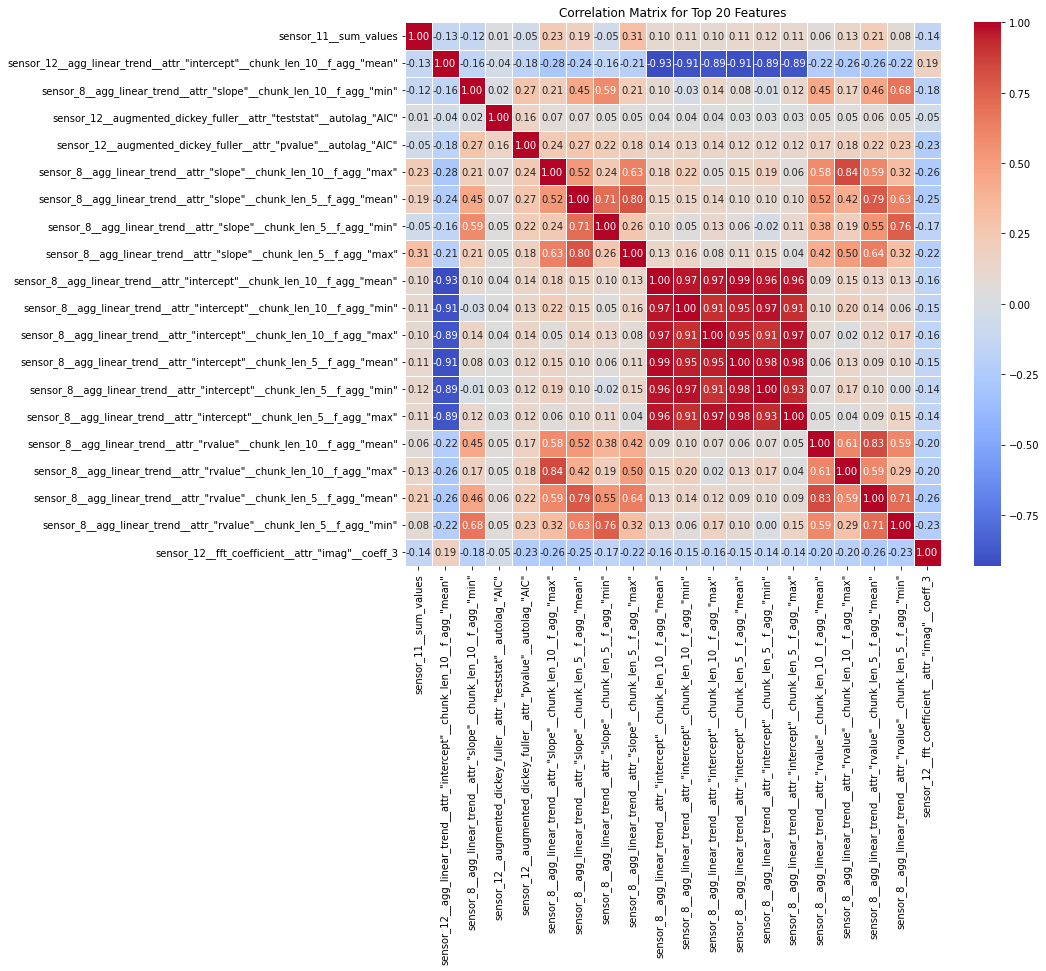

In [44]:
import seaborn as sns

# Assuming top_20_extracted_features is a DataFrame containing the top 20 features
# Calculate the correlation matrix
correlation_matrix = top_20_extracted_features.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Top 20 Features")
plt.show()

In [56]:
scaler = StandardScaler().fit(top_20_extracted_features)
relevant_features_scaled = scaler.transform(top_20_extracted_features)

# Convert the scaled data back to a DataFrame if needed
relevant_features_scaled_df = pd.DataFrame(relevant_features_scaled, columns=top_20_extracted_features.columns)

# Display the scaled DataFrame
relevant_features_scaled_df.head()

,sensor_11__sum_values,"sensor_12__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""","sensor_12__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","sensor_12__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","sensor_8__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","sensor_8__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","sensor_12__fft_coefficient__attr_""imag""__coeff_3"
0,-3.806805,-0.029821,-0.127012,-0.019170,-0.497968,-0.008055,-0.069947,-0.087939,0.027678,0.008296,0.019836,-0.00977,0.015666,0.009717,0.014331,0.426788,0.262142,0.192755,0.132896,0.048292
1,-3.698726,-0.029821,-0.127012,-0.019170,-0.497968,-0.008055,-0.069947,-0.087939,0.027678,0.008296,0.019836,-0.00977,0.015666,0.009717,0.014331,0.426788,0.262142,0.192755,0.132896,0.048292
2,-3.591149,-0.029821,-0.127012,-0.019170,-0.497968,-0.008055,-0.069947,-0.087939,0.027678,0.008296,0.019836,-0.00977,0.015666,0.009717,0.014331,0.426788,0.262142,0.192755,0.132896,0.048292
3,-3.483890,-0.029821,-0.127012,0.287996,2.210828,-0.008055,-0.069947,-0.087939,0.027678,0.008296,0.019836,-0.00977,0.015666,0.009717,0.014331,0.426788,0.262142,0.192755,0.132896,0.048292
4,-3.376289,-0.029821,-0.127012,0.175063,0.070870,-0.008055,-0.069947,-0.087939,0.027678,0.008296,0.019836,-0.00977,0.015666,0.009717,0.014331,0.426788,0.262142,0.192755,0.132896,0.048292


In [57]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(relevant_features_scaled_df, y, test_size=0.2, random_state=42)

In [58]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = mse**0.5
rmse

23.583859462907668

In [85]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = nb_classifier.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = mse**0.5
rmse

90.16792077831703

In [82]:
from sklearn.svm import SVR
svm_regressor = SVR(kernel='linear')
svm_regressor.fit(X_train, y_train)

y_pred_adjusted = svm_regressor.predict(X_val)
mse_adjusted = mean_squared_error(y_val, y_pred_adjusted)
rmse_adjusted = mse_adjusted ** 0.5

rmse_adjusted

43.15063958553517

In [61]:
rolled_df.groupby(['unit_number','id'])['piecewise_rul'].last()

unit_number
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
Name: piecewise_rul, Length: 100, dtype: float64

In [62]:
fd001_test_path = os.path.join(path, 'test_FD001.txt')

# Define column names to match the training data
columns = [
    'unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3',
] + [f'sensor_{i}' for i in range(1, 22)]  # 26 columns in total

# Load the FD001 test data
fd001_test_data = pd.read_csv(fd001_test_path, delim_whitespace=True, header=None, names=columns)

# Display the first few rows of the FD001 test data
fd001_test_data

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [63]:
window_size = 40  

rolled_test = roll_time_series(
    fd001_test_data,
    column_id='unit_number',
    column_sort='time_in_cycles',
    max_timeshift=window_size - 1,  
    min_timeshift=0,
    rolling_direction=1  
)

rolled_test.head()

Rolling: 100%|██████████| 51/51 [00:07<00:00,  6.51it/s]


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,id
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,"(1, 1)"
100,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,"(1, 2)"
101,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,"(1, 2)"
300,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,"(1, 3)"
301,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,"(1, 3)"


In [64]:
long_rolled_test = rolled_test.melt(
    id_vars=['id', 'time_in_cycles', 'unit_number'], 
    value_vars=['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 
                'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 
                'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21'], 
    var_name='feature', 
    value_name='value'
)

In [66]:
rolled_test_features = extract_features(
    long_rolled_test,
    column_id='id',  # Each rolling window has a unique 'id'
    column_sort='time_in_cycles',  # Sort by time within each window
    column_kind='feature',  # Sensor name now in 'feature' column
    column_value='value',  # Sensor values now in 'value' column
    n_jobs=4
)

Feature Extraction: 100%|██████████| 20/20 [16:35<00:00, 49.79s/it]  


In [67]:
rolled_test_features

sensor_11__variance_larger_than_standard_deviation  \
1   1                                                  0.0    
    2                                                  0.0    
    3                                                  0.0    
    4                                                  0.0    
    5                                                  0.0    
...                                                    ...    
100 194                                                0.0    
    195                                                0.0    
    196                                                0.0    
    197                                                0.0    
    198                                                0.0    

         sensor_11__has_duplicate_max  sensor_11__has_duplicate_min  \
1   1                             0.0                           0.0   
    2                             0.0                           0.0   
    3                             1.0                           0.0   
    4                             1.0                           0.0   
    5                             1.0                           0.0   
...                               ...                           ...   
100 194                           0.0                           0.0   
    195                           0.0                           0.0   
    196                           0.0                           0.0   
    197                           0.0                           0.0   
    198                           0.0                           0.0   

         sensor_11__has_duplicate  sensor_11__sum_values  \
1   1                         0.0                  47.20   
    2                         0.0                  94.70   
    3                         1.0                 142.20   
    4                         1.0                 189.48   
    5                         1.0                 236.79   
...                           ...                    ...   
100 194                       1.0                1902.02   
    195                       1.0                1901.87   
    196                       1.0                1902.21   
    197                       1.0                1902.43   
    198                       1.0                1902.77   

         sensor_11__abs_energy  sensor_11__mean_abs_change  \
1   1                2227.8400                         NaN   
    2                4484.0900                    0.300000   
    3                6740.3400                    0.150000   
    4                8975.7384                    0.173333   
    5               11213.9745                    0.137500   
...                        ...                         ...   
100 194             90442.7024                    0.119487   
    195             90428.3999                    0.108462   
    196             90460.6319                    0.105128   
    197             90481.5319                    0.104359   
    198             90513.9203                    0.108462   

         sensor_11__mean_change  sensor_11__mean_second_derivative_central  \
1   1                       NaN                                        NaN   
    2                  0.300000                                        NaN   
    3                  0.150000                                  -0.150000   
    4                  0.026667                                  -0.130000   
    5                  0.027500                                  -0.045000   
...                         ...                                        ...   
100 194               -0.001538                                   0.008289   
    195                0.009487                                  -0.003289   
    196                0.004615                                  -0.001316   
    197                0.003846                                   0.000921   
    198                0.009487                                   0.003289 

In [68]:
impute(rolled_test_features)
selected_features = top_20_extracted_features.columns 

relevant_test_features = rolled_test_features[selected_features]

# Assuming you have a scaler fitted on the training data's relevant features
relevant_test_features_scaled = scaler.transform(relevant_test_features)

# Convert to DataFrame if needed for further analysis or compatibility
relevant_test_features_scaled_df = pd.DataFrame(relevant_test_features_scaled, columns=selected_features)

# Display the first few rows of the processed test features
relevant_test_features_scaled_df.head()

c:\Users\owner\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['sensor_11__fft_coefficient__attr_"real"__coeff_21'
 'sensor_11__fft_coefficient__attr_"real"__coeff_22'
 'sensor_11__fft_coefficient__attr_"real"__coeff_23' ...
 'sensor_9__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'sensor_9__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'sensor_9__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,sensor_11__sum_values,"sensor_12__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""","sensor_12__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","sensor_12__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min""","sensor_8__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","sensor_8__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","sensor_8__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","sensor_8__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","sensor_8__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","sensor_12__fft_coefficient__attr_""imag""__coeff_3"
0,-3.807419,0.5036,-0.28334,-0.049357,-0.498144,-0.225204,-0.208238,-0.20616,-0.124701,-0.431527,-0.392602,-0.370153,-0.41006,-0.405145,-0.372981,0.040738,-0.138106,-0.153369,-0.134926,0.255579
1,-3.699318,0.5036,-0.28334,-0.049357,-0.498144,-0.225204,-0.208238,-0.20616,-0.124701,-0.431527,-0.392602,-0.370153,-0.41006,-0.405145,-0.372981,0.040738,-0.138106,-0.153369,-0.134926,0.255579
2,-3.591217,0.5036,-0.28334,-0.049357,-0.498144,-0.225204,-0.208238,-0.20616,-0.124701,-0.431527,-0.392602,-0.370153,-0.41006,-0.405145,-0.372981,0.040738,-0.138106,-0.153369,-0.134926,0.255579
3,-3.483617,0.5036,-0.28334,0.287929,2.209874,-0.225204,-0.208238,-0.20616,-0.124701,-0.431527,-0.392602,-0.370153,-0.41006,-0.405145,-0.372981,0.040738,-0.138106,-0.153369,-0.134926,0.255579
4,-3.375948,0.5036,-0.28334,0.172743,0.039869,-0.225204,-0.208238,-0.20616,-0.124701,-0.431527,-0.392602,-0.370153,-0.41006,-0.405145,-0.372981,0.040738,-0.138106,-0.153369,-0.134926,0.255579


In [70]:
rul_file_path = os.path.join(path, 'RUL_FD001.txt')
true_rul = pd.read_csv(rul_file_path, header=None, names=['RUL'])

# Assign the true RUL values to Y_test
Y_test = true_rul['RUL']
Y_test.head()

0    112
1     98
2     69
3     82
4     91
Name: RUL, dtype: int64

In [72]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(relevant_test_features_scaled_df)

In [75]:
len(y_pred)

13096

In [78]:
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred 
temp

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,prediction
id,,,,,,,,,,,,,,,,,,,,,
"(1, 1)",1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,236.352173
"(1, 2)",1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,228.288971
"(1, 3)",1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,226.280365
"(1, 4)",1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,217.413345
"(1, 5)",1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,209.918533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(100, 194)",100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,38.507954
"(100, 195)",100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,45.952175
"(100, 196)",100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,29.588377


In [80]:
Y_pred = temp.groupby('unit_number')['prediction'].last()

In [81]:
mse = mean_squared_error(Y_test, Y_pred)
rmse = mse**0.5
rmse

26.18982946749114

In [86]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(relevant_test_features_scaled_df)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred 
Y_pred = temp.groupby('unit_number')['prediction'].last()
mse = mean_squared_error(Y_test, Y_pred)
rmse = mse**0.5
rmse

99.1536686159418

In [89]:
from sklearn.svm import SVR
svm_regressor = SVR(kernel='linear')
svm_regressor.fit(X_train, y_train)

y_pred = svm_regressor.predict(relevant_test_features_scaled_df)
temp['prediction'] = y_pred 
Y_pred = temp.groupby('unit_number')['prediction'].last()
mse = mean_squared_error(Y_test, Y_pred)
rmse = mse**0.5
rmse

25.24684929248226